In [1]:
# Use seaborn for pairplot
!pip install -q seaborn

# Use some functions from tensorflow_docs
!pip install -q git+https://github.com/tensorflow/docs

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

print(tf.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


2.2.0-rc2




1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
   2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
   3. month - month of the year: "jan" to "dec" 
   4. day - day of the week: "mon" to "sun"
   5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
   6. DMC - DMC index from the FWI system: 1.1 to 291.3 
   7. DC - DC index from the FWI system: 7.9 to 860.6 
   8. ISI - ISI index from the FWI system: 0.0 to 56.10
   9. temp - temperature in Celsius degrees: 2.2 to 33.30
   10. RH - relative humidity in %: 15.0 to 100
   11. wind - wind speed in km/h: 0.40 to 9.40 
   12. rain - outside rain in mm/m2 : 0.0 to 6.4 
   13. area - the burned area of the forest (in ha): 0.00 to 1090.84 
   (this output variable is very skewed towards 0.0, thus it may make
    sense to model with the logarithm transform). 




In [3]:
dataset_path = keras.utils.get_file("forestfires.csv", "http://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv")


32768/25478 [======================================] - 0s 4us/step


In [0]:
column_names = ['x', 'y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area']

In [0]:
dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=",", skipinitialspace=True,skiprows=1)


In [0]:
dataset

,x,y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


In [0]:
dataset.pop('day')
dataset.pop('DMC')
dataset.pop('DC')
dataset.pop('x')
dataset.pop('y')
dataset.pop('FFMC')

0      86.2
1      90.6
2      90.6
3      91.7
4      89.3
       ... 
512    81.6
513    81.6
514    81.6
515    94.4
516    79.5
Name: FFMC, Length: 517, dtype: float64

In [0]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,ISI,temp,RH,wind,rain,area,apr,aug,dec,feb,jan,jul,jun,mar,may,nov,oct,sep
512,1.9,27.8,32,2.7,0.0,6.44,0,1,0,0,0,0,0,0,0,0,0,0
513,1.9,21.9,71,5.8,0.0,54.29,0,1,0,0,0,0,0,0,0,0,0,0
514,1.9,21.2,70,6.7,0.0,11.16,0,1,0,0,0,0,0,0,0,0,0,0
515,11.3,25.6,42,4.0,0.0,0.00,0,1,0,0,0,0,0,0,0,0,0,0
516,1.1,11.8,31,4.5,0.0,0.00,0,0,0,0,0,0,0,0,0,1,0,0


In [0]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

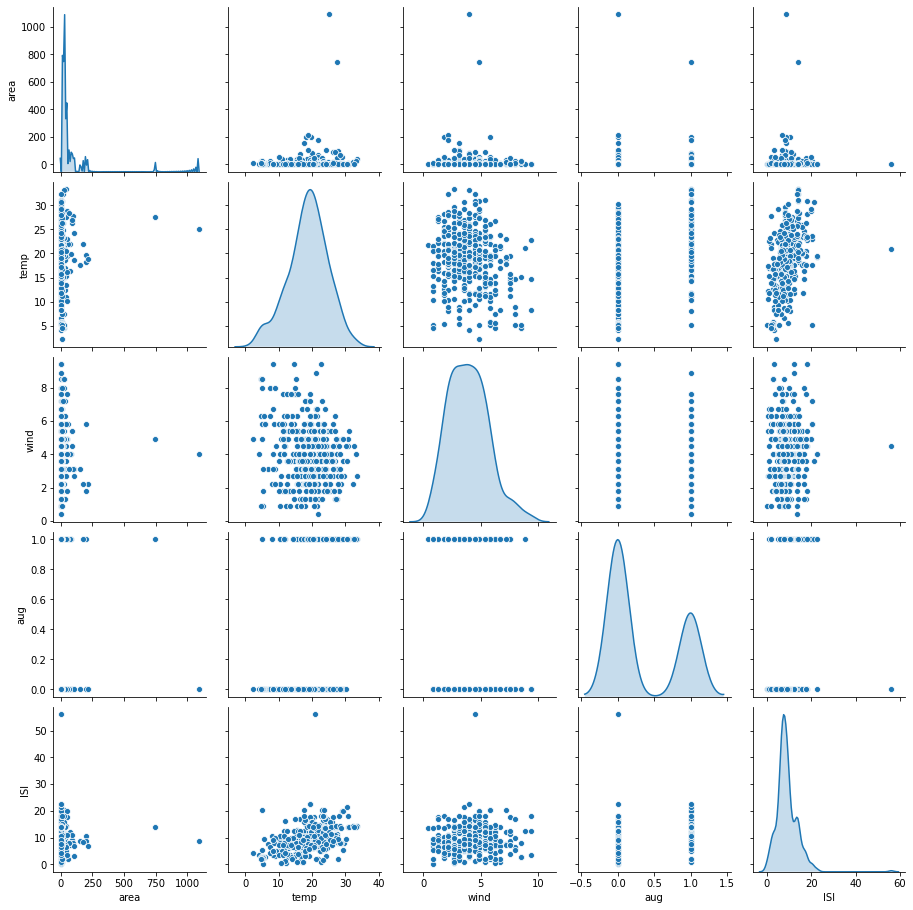

In [0]:
sns.pairplot(train_dataset[["area", "temp", "wind", 'aug', 'ISI']], diag_kind="kde")


In [0]:
train_stats = train_dataset.describe()
train_stats.pop("area")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
ISI,414.0,9.136957,4.760950,0.0,6.5,8.40,11.075,56.1
temp,414.0,18.800000,5.857786,2.2,15.4,19.15,22.800,33.3
RH,414.0,44.142512,16.491291,15.0,32.0,41.00,53.000,100.0
wind,414.0,3.967874,1.739613,0.4,2.7,4.00,4.900,9.4
rain,414.0,0.021256,0.320007,0.0,0.0,0.00,0.000,6.4
apr,414.0,0.016908,0.129084,0.0,0.0,0.00,0.000,1.0
aug,414.0,0.347826,0.476857,0.0,0.0,0.00,1.000,1.0
dec,414.0,0.014493,0.119655,0.0,0.0,0.00,0.000,1.0
feb,414.0,0.043478,0.204178,0.0,0.0,0.00,0.000,1.0
jan,414.0,0.004831,0.069421,0.0,0.0,0.00,0.000,1.0


In [0]:
train_labels = train_dataset.pop('area')
test_labels = test_dataset.pop('area')

In [0]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [0]:
def build_model():
  model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-2)

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=optimizer,
                metrics=['mae', 'mse', 'acc'])
  return model

In [0]:
model = build_model()


In [0]:
model.summary()


Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_117 (Dense)            (None, 128)               2304      
_________________________________________________________________
dense_118 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_119 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_120 (Dense)            (None, 1)                 33        
Total params: 12,673
Trainable params: 12,673
Non-trainable params: 0
_________________________________________________________________


In [0]:
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, acc:0.0363,  loss:5510.2749,  mae:17.8385,  mse:5851.0522,  val_acc:0.0000,  val_loss:862.7006,  val_mae:13.1948,  val_mse:988.0359,  
....................................................................................................
Epoch: 100, acc:0.0997,  loss:4088.2966,  mae:16.2727,  mse:4295.4805,  val_acc:0.0723,  val_loss:1036.0577,  val_mae:14.7207,  val_mse:1180.0269,  
....................................................................................................
Epoch: 200, acc:0.1329,  loss:1271.1436,  mae:9.5967,  mse:1345.9473,  val_acc:0.0241,  val_loss:2008.4976,  val_mae:20.0444,  val_mse:2308.5605,  
....................................................................................................
Epoch: 300, acc:0.0816,  loss:3631.9678,  mae:11.9585,  mse:3847.8735,  val_acc:0.0602,  val_loss:1941.1713,  val_mae:20.2583,  val_mse:2173.4338,  
....................................................................................................
Epoc

In [0]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,acc,val_loss,val_mae,val_mse,val_acc,epoch
995,0.522308,13.225430,5611.137695,0.444109,2.300346,12.577590,1020.454529,0.192771,995
996,0.479364,13.237928,5610.904297,0.444109,2.287000,12.577202,1020.398132,0.192771,996
997,0.588750,13.238435,5611.076172,0.444109,2.285692,12.578115,1020.806824,0.192771,997
998,0.521209,13.225896,5608.600098,0.441088,2.290929,12.613243,1023.015747,0.192771,998
999,0.467260,13.250200,5607.671387,0.444109,2.317344,12.607463,1018.700684,0.192771,999


In [0]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [AREA]')

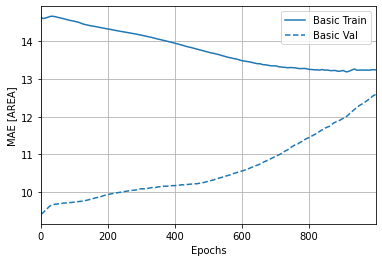

In [0]:
plotter.plot({'Basic': history}, metric = "mae")
plt.ylabel('MAE [AREA]')

Text(0, 0.5, 'MSE [AREA^2]')

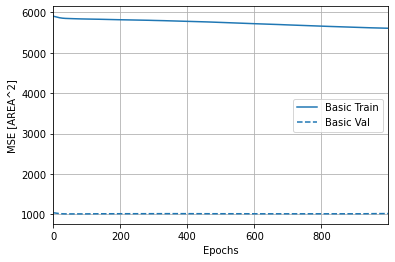

In [0]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylabel('MSE [AREA^2]')


In [0]:
model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, acc:0.1239,  loss:5548.0801,  mae:14.6571,  mse:5896.1143,  val_acc:0.0000,  val_loss:886.0342,  val_mae:9.5212,  val_mse:1023.4276,  
.................

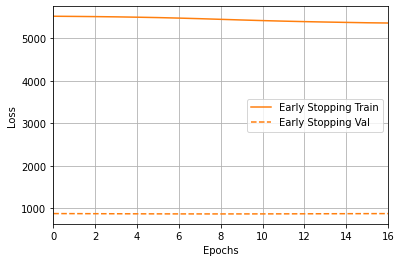

In [0]:
plotter.plot({'Early Stopping': early_history}, metric = "loss")

In [0]:
loss, mae, mse , _= model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} Hectares".format(mae))

4/4 - 0s - loss: 1004.2307 - mae: 14.8107 - mse: 1200.9363 - acc: 0.0000e+00
Testing set Mean Abs Error: 14.81 Hectares
